# 7. 인물사진을 만들어 보자

## Step 1) 인물모드 직접 해 보기


### (1) DeepLab 모델 준비

In [26]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [36]:
# DeepLabModel 클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [41]:
img_resized, seg_map = MODEL.run(img_orig)

In [42]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [43]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

### (2) 배경 블러처리

이미지사이즈는 (512, 520, 3)이다.


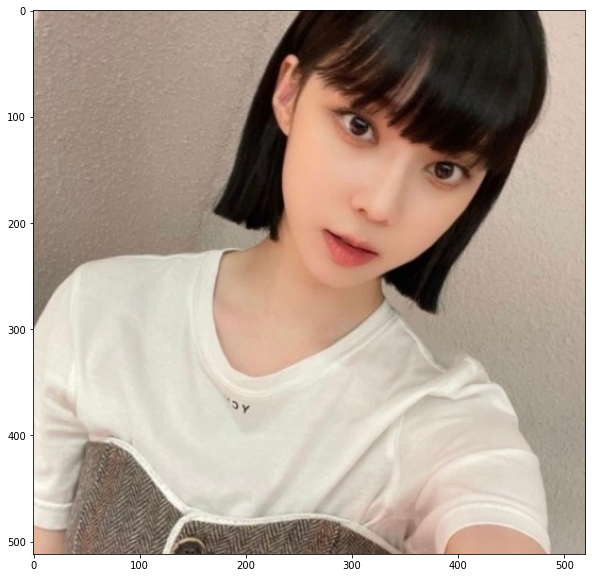

In [44]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_images.jpeg' 
img_orig = cv2.imread(img_path) 
print ('이미지사이즈는 {}이다.'.format(img_orig.shape))

plt.figure(figsize=(10, 10)) # 출력 사이즈 조정

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

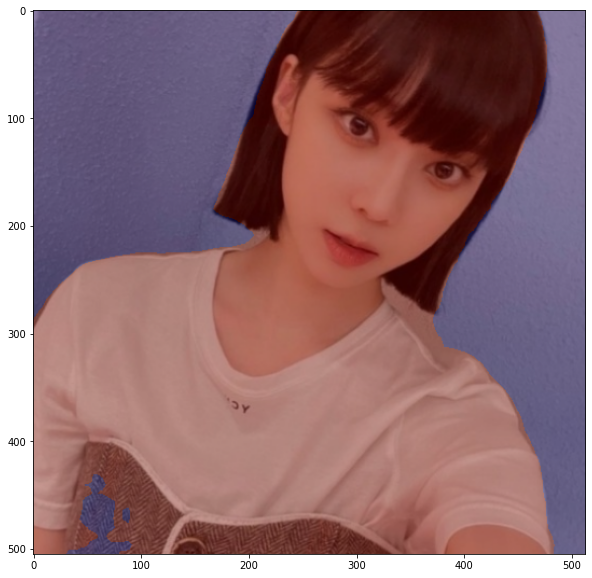

In [45]:
#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

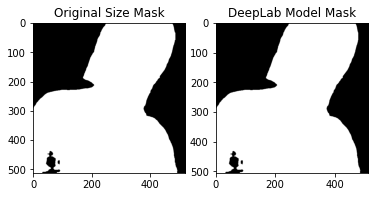

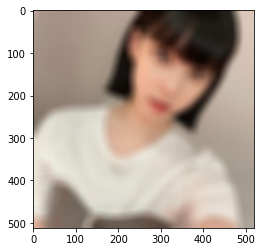

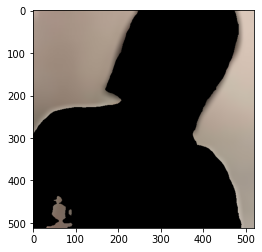

In [46]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25)) #(25,25은 blurring  kernel size를 뜻합니다. 

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

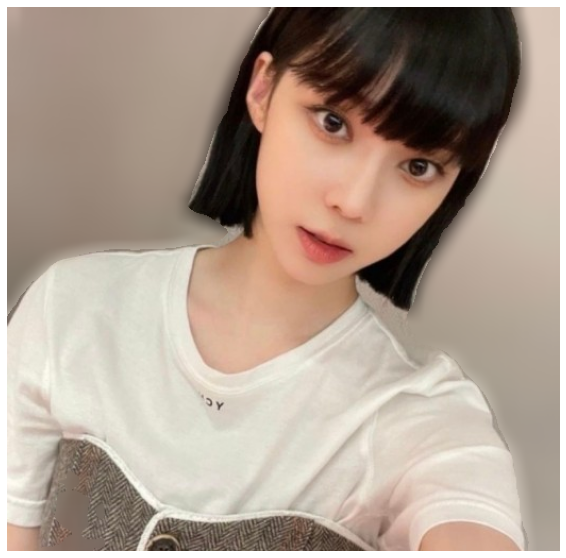

In [50]:
# 배경 영상과 사람 영상을 합치기
plt.figure(figsize=(10, 10))

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### - 고양이사진 

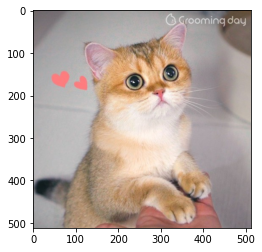

In [51]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat.jpeg' 
cat_img_orig = cv2.imread(cat_img_path) 

plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

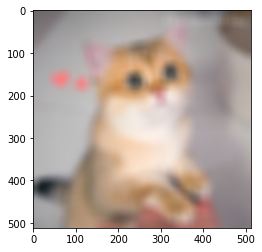

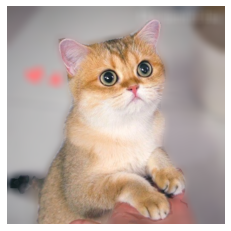

In [57]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(cat_img_orig)

cat_img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
cat_img_mask = seg_map * (255/seg_map.max()) 
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)
plt.show()

# 세그멘테이션 결과(mask)를 원래 크기로 복원
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
cat_img_orig_blur = cv2.blur(cat_img_orig, (25,25))
plt.imshow(cv2.cvtColor( cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.show()

# 배경과 고양이 합치기
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Step 2) 사진에서 문제점 찾기

인물이 돋보이게 되긴하지만 경계선 처리가 너무 티가 난다.


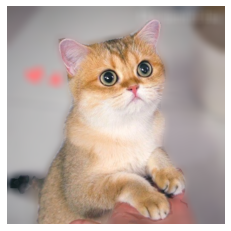

In [58]:
# 배경과 고양이 합치기
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

위에 사진에서 고양이가 아닌 부분이 블러처리가 되지 않는다. 또한 고양이 꼬리는 블러 처리 되었다.

경계선 처리와 피사체를 인식하는 모델능력을 더 키워야할 것 같다.

## Step 3) 해결 방법을 제안해 보기

포토샵에서 블러처리할때 경계선부터 블러처리를 해주고 진행하는 것으로 알고 있다.
모델이 인식할때 경계선부터 블러처리를 해주고 난 후 진행하면 더욱 나타내고 싶은 물체를 자세하게 나타낼 수 있을 것 같다.